In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [53]:
# Read in data and display first 5 rows
fn='../Data/INTERP_CTU.csv'
features = pd.read_csv(fn)
features.head()

,utvec,dv,err,temp,SM_EWT,date
0,2012.847412,0.0549,0.1532,5.38669,0.473216,2012-11-06
1,2012.850098,0.0442,0.1524,5.34453,0.474801,2012-11-07
2,2012.852783,0.0276,0.1514,5.23883,0.476454,2012-11-08
3,2012.855591,0.0165,0.1503,5.00576,0.478027,2012-11-09
4,2012.858276,0.0112,0.1500,4.65426,0.479654,2012-11-10


In [54]:
# Assuming you have three time series: dv, temperature, and soil moisture
# Replace these arrays with your actual data
np.random.seed(42)

dv = np.asarray(features.dv) 
dv = dv / np.max(dv)

temperature = np.asarray(features.temp)
temperature = temperature - np.mean(temperature)
temperature = temperature / np.max(temperature)

soil_moisture = np.asarray(features.SM_EWT)
#soil_moisture = 0.5 * dv + 0.2 * temperature +  2 * soil_moisture
soil_moisture = soil_moisture - np.mean(soil_moisture)
soil_moisture = soil_moisture / np.max(soil_moisture)


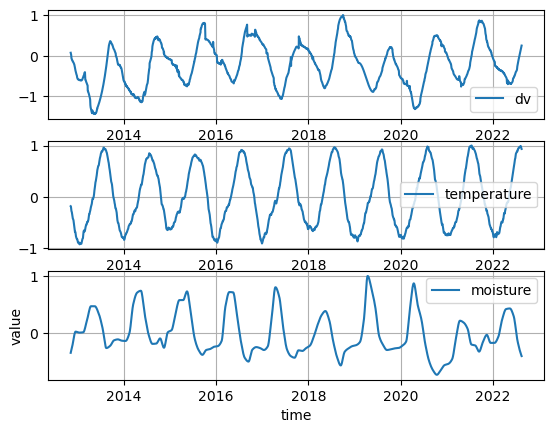

In [55]:
fig, ax = plt.subplots(3,1)
# Plot the true vs predicted soil moisture values
ax[0].plot(features.utvec, dv, label='dv')
ax[1].plot(features.utvec, temperature, label='temperature')
ax[2].plot(features.utvec, soil_moisture, label='moisture')
plt.xlabel('time')
plt.ylabel('value')
ax[0].legend();ax[1].legend();ax[2].legend();
ax[0].grid(True);ax[1].grid(True);ax[2].grid(True);
plt.show()


In [56]:

# Combine input features (dv and temperature) into a single array
X = np.column_stack((dv, temperature))

# Standardize input features and target variable
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(soil_moisture.reshape(-1, 1)).flatten()


In [57]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()


In [99]:
# Inverse transform to get back the original scale of soil moisture for training set
y_train_inverse = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)


In [100]:
# Normalize input data
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [101]:

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [102]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        if self.verbose:
            print(f'Early Stopping Counter: {self.counter}/{self.patience}')

        return self.early_stop


Epoch 1/120 | Train Loss: 0.2918 | Test Loss: 0.1801
Epoch 2/120 | Train Loss: 0.2631 | Test Loss: 0.1721
Epoch 3/120 | Train Loss: 0.2364 | Test Loss: 0.1644
Epoch 4/120 | Train Loss: 0.2126 | Test Loss: 0.1572
Epoch 5/120 | Train Loss: 0.1909 | Test Loss: 0.1503
Epoch 6/120 | Train Loss: 0.1715 | Test Loss: 0.1439
Epoch 7/120 | Train Loss: 0.1536 | Test Loss: 0.1376
Epoch 8/120 | Train Loss: 0.1377 | Test Loss: 0.1317
Epoch 9/120 | Train Loss: 0.1239 | Test Loss: 0.1261
Epoch 10/120 | Train Loss: 0.1115 | Test Loss: 0.1209
Epoch 11/120 | Train Loss: 0.1009 | Test Loss: 0.1159
Epoch 12/120 | Train Loss: 0.0912 | Test Loss: 0.1112
Epoch 13/120 | Train Loss: 0.0828 | Test Loss: 0.1067
Epoch 14/120 | Train Loss: 0.0760 | Test Loss: 0.1024
Epoch 15/120 | Train Loss: 0.0707 | Test Loss: 0.0984
Epoch 16/120 | Train Loss: 0.0664 | Test Loss: 0.0946
Epoch 17/120 | Train Loss: 0.0637 | Test Loss: 0.0912
Epoch 18/120 | Train Loss: 0.0620 | Test Loss: 0.0879
Epoch 19/120 | Train Loss: 0.0613 | T

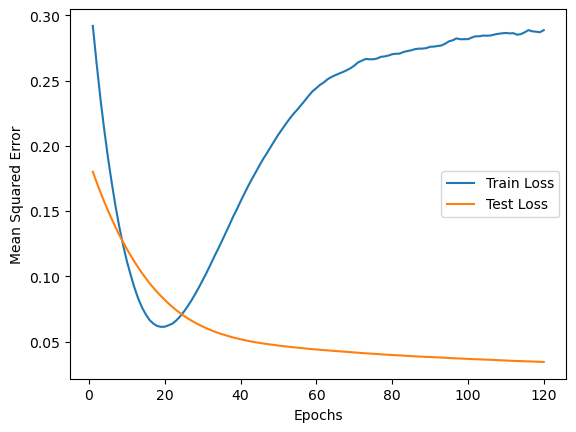

In [103]:

# Instantiate the model
input_size = X.shape[1]
hidden_size = 128
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate schedule
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

# Early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

# Lists to store training history
train_loss_history = []
test_loss_history = []
# Lists to store iteration or epoch numbers
epochs_list = []


# Training loop
num_epochs = 120
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

    # Inverse transform to get back the original scale of soil moisture
    y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    # Calculate and log the Mean Squared Error on the training and test sets
    train_loss = mean_squared_error(y_train_inverse, model(X_train_tensor).detach().numpy().flatten())
    test_loss = mean_squared_error(y_test_inverse, y_pred_inverse)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    epochs_list.append(epoch + 1)

    print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')

# Plot the loss over epochs
plt.plot(epochs_list, train_loss_history, label='Train Loss')
plt.plot(epochs_list, test_loss_history, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [104]:

# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.numpy()

# Inverse transform to get back the original scale of soil moisture
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculate and print the Mean Squared Error on the test set
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error on Test Set: {mse}')


Mean Squared Error on Test Set: 0.034431839057046235


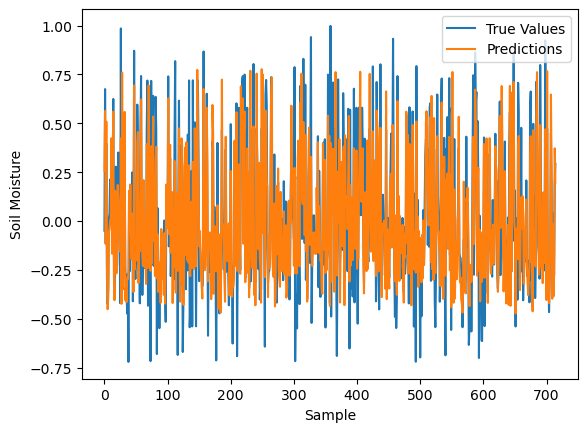

In [105]:

# Plot the true vs predicted soil moisture values
plt.plot(y_test_inverse, label='True Values')
plt.plot(y_pred_inverse, label='Predictions')
plt.xlabel('Sample')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()

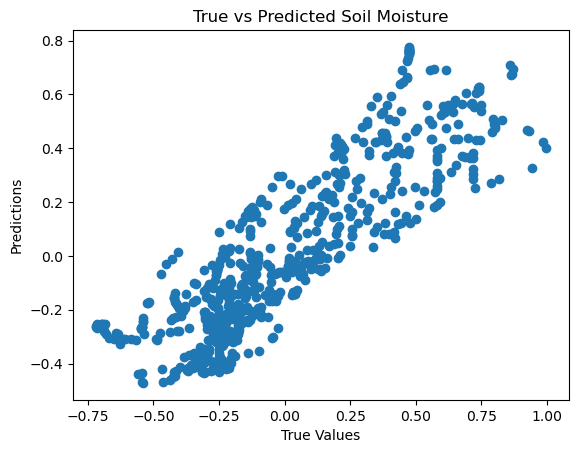

In [106]:
plt.scatter(y_test_inverse, y_pred_inverse)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Soil Moisture')
plt.show()


In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error: {mse:.4f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error:  {rmse:.4f}')

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error:  {mae:.4f}')

r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f'R-squared: {r2:.4f}')


Mean Squared Error: 0.0344
Root Mean Squared Error:  0.1856
Mean Absolute Error:  0.1475
R-squared: 0.7449
